## MPAA rating prediction

In [1]:
import pandas as pd
import numpy as np
import warnings
import re
import pickle
import seaborn as sns

%matplotlib inline
warnings.filterwarnings('ignore')

Import dataset :: using the rotten tomatoes dataset

In [2]:
dataset_df = pd.read_csv( './rtt_dataset/all_movie.csv' )
dataset_df = dataset_df[['Title', 'Rating', 'Description']]
dataset_df.columns = dataset_df.columns.str.strip()
dataset_df.head(4)

,Title,Rating,Description
0,The Mummy: Tomb of the Dragon Emperor,PG-13,The Fast and the Furious director Rob Cohen co...
1,The Masked Saint,PG-13,The journey of a professional wrestler who bec...
2,Spy Hard,PG-13,"Dead pan Leslie Nielsen stars as Dick Steele, ..."
3,Der Baader Meinhof Komplex (The Baader Meinhof...,R,Director Uli Edel teams with screenwriter Bern...


In [3]:
# finding unique mpaa rating in the dataset
dataset_df['Rating'].unique()

array(['PG-13 ', 'PG-13', 'R ', 'NR', 'PG', 'G', 'PG ', 'R', 'G ', 'NR ',
       'NC17', 'NC17 '], dtype=object)

In [4]:
# clean mpaa ratings
mpaa_fix = {
    'PG-13 ' : 'PG-13',
    'R ' : 'R',
    'PG ': 'PG',
    'G ' : 'G',
    'NR ': 'NR',
    'NC17 ': 'NC17'
}
for i, rating in dataset_df['Rating'].iteritems():
    if rating in mpaa_fix.keys():
        fix_val = mpaa_fix.get(rating)
        dataset_df.iloc[i]['Rating'] = fix_val
dataset_df['Rating'].unique()

array(['PG-13', 'R', 'NR', 'PG', 'G', 'NC17'], dtype=object)

In [5]:
# Clean the movie description
def clean_description( text_str ):
    text = re.sub('[^a-zA-Z]',  ' ', text_str)
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text

for i, description in dataset_df['Description'].iteritems():
    dataset_df.iloc[i]['Description'] = clean_description( str(description) )

In [6]:
pickle.dump(dataset_df, open('./data/dataset_df_cleaned_n_sample.pkl', 'wb'))

## Data Distribution

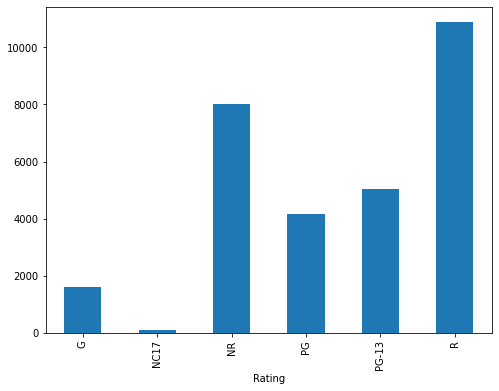

In [7]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
dataset_df.groupby('Rating')['Description'].count().plot.bar(ylim=0)
plt.show()

In [8]:
## drop G, NC-17
dataset_df = dataset_df[dataset_df.Rating != 'NC17'] 
dataset_df = dataset_df[dataset_df.Rating != 'G'] 

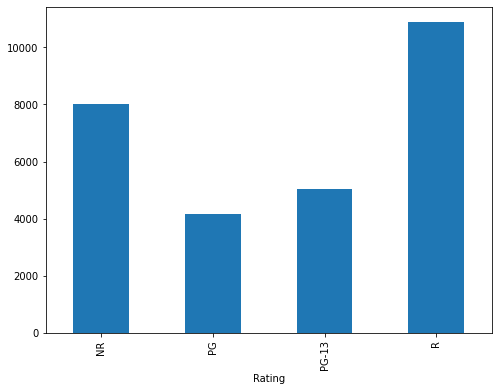

In [9]:
fig = plt.figure(figsize=(8,6))
dataset_df.groupby('Rating')['Description'].count().plot.bar(ylim=0)
plt.show()

## Use same amount of labels

In [10]:
PG_count = dataset_df[dataset_df.Rating == 'PG'].shape
PG_count

(4172, 3)

In [11]:
dataset_df = dataset_df.sample(frac=1).groupby('Rating').head(4172)
dataset_df

,Title,Rating,Description
20664,Americano,NR,Americano functions both as an homage to Demy ...
20984,Headspace,R,A twenty five year old man whose chance encoun...
838,Hawaii,NR,Hawaii hadn even begun filming when director F...
25881,Trash,R,Set in an unnamed Third World country three ki...
1111,A Better Tomorrow,R,John Woo established himself as one of Hong Ko...
...,...,...,...
18084,Gunga Din,PG,Though Rudyard Kipling poem Gunga Din makes sw...
14375,388 Arletta Avenue,PG,In this fresh subversive take on the found foo...
19278,Radio,PG,James Robert Kennedy nicknamed Radio because o...
29373,Sheena,PG,A female shaman finds young girl lost in the j...


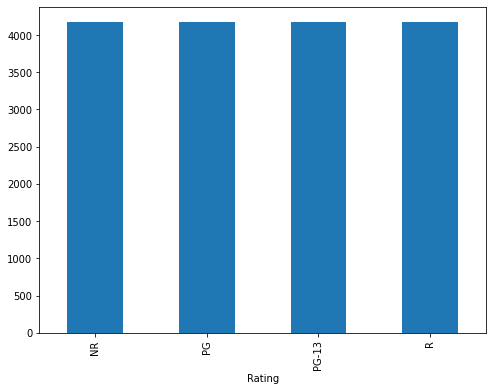

In [12]:
fig = plt.figure(figsize=(8,6))
dataset_df.groupby('Rating')['Description'].count().plot.bar(ylim=0)
plt.show()

## Training model

In [13]:
training_df = pickle.load( open('./data/dataset_df_cleaned_n_sample.pkl', 'rb') )

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, LSTM, Embedding, GlobalMaxPooling1D

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [15]:
_y = training_df['Rating']
encoder = LabelEncoder()
Y = encoder.fit_transform(_y)
Y

array([4, 4, 4, ..., 5, 4, 4])

In [16]:
X = training_df['Description']
X

0        The Fast and the Furious director Rob Cohen co...
1        The journey of professional wrestler who becom...
2        Dead pan Leslie Nielsen stars as Dick Steele a...
3        Director Uli Edel teams with screenwriter Bern...
4        One of cluster of late films about the Vietnam...
                               ...                        
29805    Filmed at least nine times over the last nine ...
29806    Fred MacMurray stars in this Walt Disney comed...
29807    A resident of rd century Earth becomes involve...
29808    Supernova chronicles the search and rescue pat...
29809    For years there have been documented cases of ...
Name: Description, Length: 29810, dtype: object

## Train, test split

In [17]:
X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=0.3, random_state=40 )

In [18]:
Y_train = to_categorical(Y_train)
Y_test  = to_categorical(Y_test)

In [19]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

In [20]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test  = tokenizer.texts_to_sequences(X_test)

In [21]:
vocabulary_size = len(tokenizer.word_index) + 1
maxlen = 400 # Only concider first 400 words of each description

X_train = pad_sequences( X_train, maxlen=maxlen )
X_test  = pad_sequences( X_test, maxlen=maxlen )

## Use GloVe : Global Vectors for Word Representation
https://nlp.stanford.edu/projects/glove/

GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space. 

In [22]:
glove_file = open('./glove.6B/glove.6B.100d.txt', encoding='utf8')

In [23]:
embedd_dictionary = dict()
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dims = np.asarray(records[1:], dtype='float32')
    embedd_dictionary[word] = vector_dims

glove_file.close()

In [24]:
embedd_matrix = np.zeros((vocabulary_size, 100))
for word, index in tokenizer.word_index.items():
    embedd_vector = embedd_dictionary.get(word)
    if embedd_vector is not None:
        embedd_matrix[index] = embedd_vector

## Build the NN Model

In [25]:
model = Sequential()
model.add(Embedding(input_dim=vocabulary_size, output_dim=100, weights=[embedd_matrix], trainable=False))
model.add(LSTM(units=256, dropout=0.4, recurrent_dropout=0.4))
model.add(Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         5635900   
_________________________________________________________________
lstm (LSTM)                  (None, 256)               365568    
_________________________________________________________________
dense (Dense)                (None, 6)                 1542      
Total params: 6,003,010
Trainable params: 367,110
Non-trainable params: 5,635,900
_________________________________________________________________


In [26]:
hist = model.fit(X_train, Y_train, batch_size=128, epochs=34, validation_split=0.30, verbose=1)

Epoch 1/34
115/115 [==============================] - 105s 898ms/step - loss: 1.4930 - accuracy: 0.3560 - val_loss: 1.4476 - val_accuracy: 0.3798
Epoch 2/34
115/115 [==============================] - 104s 908ms/step - loss: 1.4153 - accuracy: 0.3847 - val_loss: 1.4082 - val_accuracy: 0.4060
Epoch 3/34
115/115 [==============================] - 105s 915ms/step - loss: 1.3635 - accuracy: 0.4119 - val_loss: 1.3052 - val_accuracy: 0.4451
Epoch 4/34
115/115 [==============================] - 103s 899ms/step - loss: 1.2965 - accuracy: 0.4549 - val_loss: 1.2598 - val_accuracy: 0.4728
Epoch 5/34
115/115 [==============================] - 104s 902ms/step - loss: 1.2585 - accuracy: 0.4635 - val_loss: 1.2267 - val_accuracy: 0.4895
Epoch 6/34
115/115 [==============================] - 103s 899ms/step - loss: 1.2422 - accuracy: 0.4784 - val_loss: 1.2262 - val_accuracy: 0.4839
Epoch 7/34
115/115 [==============================] - 104s 903ms/step - loss: 1.2115 - accuracy: 0.5006 - val_loss: 1.1968 -

In [27]:
loss, acc = model.evaluate(X_test, Y_test, verbose=1)
print('loss: ', loss)
print('accuracy: ', acc)

280/280 [==============================] - 32s 113ms/step - loss: 0.9444 - accuracy: 0.6631
loss:  0.9444440603256226
accuracy:  0.6630884408950806


## Save model and tokenizer

In [28]:
# save model
model.save('./data/mpaa_classifier_n_sample.h5')

# save word tokenizer
pickle.dump(tokenizer, open('./data/tokenizer_n_sample.pkl', 'wb'))

## Metrics

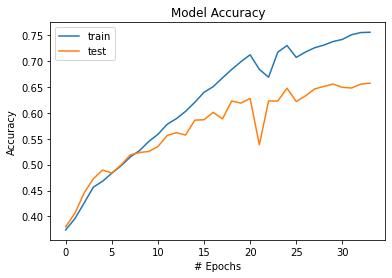

In [29]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('# Epochs')
plt.legend(['train', 'test'])
plt.show()

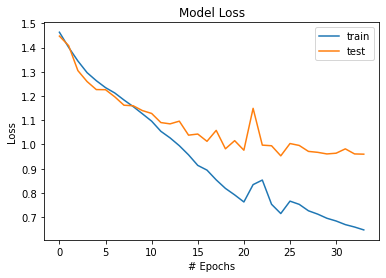

In [30]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('# Epochs')
plt.legend(['train', 'test'])
plt.show()

## Confusion Matrix

In [31]:
# load the saved model
from keras.models import load_model
model = load_model("./data/mpaa_classifier_n_sample.h5")

In [32]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')
